In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

# Set up

api_key = os.getenv('HOPSWORKS_API_KEY')
project_name = os.getenv('HOPSWORKS_PROJECT')

project = hopsworks.login(project=project_name, api_key_value=api_key)
fs = project.get_feature_store() 
secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

AQI_API_KEY = secrets.get_secret("AQI_API_KEY").value
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)

today = datetime.datetime.now() - datetime.timedelta(0)

['/home/robert/anaconda3/lib/python312.zip', '/home/robert/anaconda3/lib/python3.12', '/home/robert/anaconda3/lib/python3.12/lib-dynload', '', '/home/robert/Documents/scalable-ml/lab1-new/hbg-weather/.venv/lib/python3.12/site-packages']
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160344
2024-11-20 18:13:36,962 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)
df = feature_view.get_batch_data(start_time=None, end_time=None, read_options=None).sort_values(by='date')
df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.80s) 


,past_air_quality,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,42.354327,2019-12-09 00:00:00+00:00,14.900082,0.2,9.422101,11.842063,lahore
1,42.354327,2019-12-10 00:00:00+00:00,14.052165,0.0,8.534353,69.443985,lahore
2,264.953334,2019-12-11 00:00:00+00:00,14.975082,2.3,8.089993,99.649574,lahore
3,199.996670,2019-12-12 00:00:00+00:00,13.347999,15.8,16.904673,72.617531,lahore
4,125.423336,2019-12-13 00:00:00+00:00,12.170915,0.0,11.525623,243.006943,lahore
...,...,...,...,...,...,...,...
1796,164.996668,2024-11-15 00:00:00+00:00,20.023001,1.6,12.982480,17.241518,lahore
1797,188.106669,2024-11-16 00:00:00+00:00,18.385500,0.0,6.330782,24.163300,lahore
1798,128.040002,2024-11-17 00:00:00+00:00,17.897999,0.0,7.040739,297.781921,lahore
1799,84.966668,2024-11-17 00:00:00+00:00,17.897999,0.0,7.040739,297.781921,lahore


In [2]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

### Retreive model

mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

saved_model_dir = retrieved_model.download()
retrieved_xgboost_model = XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

### Retrieve features 

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

today_timestamp = pd.to_datetime(today)
batch_data = weather_fg.filter(weather_fg.date >= today_timestamp ).read().sort_values(by=['date'])

Connected. Call `.close()` to terminate connection gracefully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 


2024-11-20 17:29:20,170 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



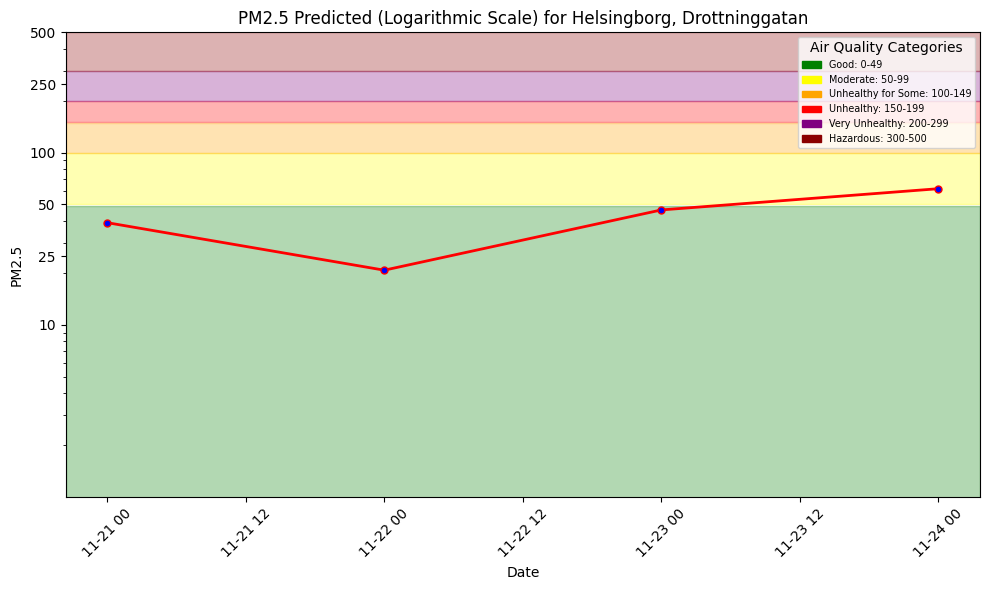

In [3]:

### Predict and upload

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
#batch_data['date'] = batch_data['date'].dt.tz_convert(None).astype('datetime64[ns]')

plt = util.plot_air_quality_forecast(city, street, batch_data, file_path="./img/pm25_forecast.png")
plt.show()


In [4]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

print(f"Batch data: {batch_data}")

monitor_fg.insert(batch_data, write_options={"wait_for_job": True})
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

# Hindcast monitoring

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()

outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

Batch data:                        date  temperature_2m_mean  precipitation_sum  \
0 2024-11-21 00:00:00+00:00                 3.40                0.2   
3 2024-11-22 00:00:00+00:00                 4.05                0.7   
2 2024-11-23 00:00:00+00:00                 5.45                0.0   
1 2024-11-24 00:00:00+00:00                 5.60                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant         city  \
0           19.995398                   246.665939  Helsingborg   
3           23.540806                   246.571289  Helsingborg   
2           30.631746                   240.422256  Helsingborg   
1           13.755580                   276.008911  Helsingborg   

   predicted_pm25          street country  days_before_forecast_day  
0       39.168438  Drottninggatan  Sweden                         1  
3       20.740093  Drottninggatan  Sweden                         2  
2       46.448105  Drottninggatan  Sweden                         3  
1       61.71344

Uploading Dataframe: 0.00% |          | Rows 0/4 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160340/jobs/named/aq_predictions_1_offline_fg_materialization/executions
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.85s) 


In [5]:
hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)

plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path="./img/pm25_hindcast_1day.png", hindcast=True)

ValueError: You are trying to merge on datetime64[us, UTC] and object columns for key 'date'. If you wish to proceed you should use pd.concat

In [ ]:
import numpy as np

scale = 5
outcome_df['predicted_pm25'] = outcome_df['pm25'] + scale * np.random.uniform(-1, 1, outcome_df.shape[0])
outcome_df.sort_values(by=['date'])
outcome_df.to_pickle('outcome_df.pkl')

2024-11-20 14:23:12,559 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

